In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
! pip install transformers -q

     |████████████████████████████████| 389kB 8.4MB/s 
     |████████████████████████████████| 696kB 55.0MB/s 
     |████████████████████████████████| 1.0MB 63.4MB/s 
     |████████████████████████████████| 860kB 60.6MB/s 


In [0]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [0]:
seed = 42

import random
random.seed(seed)

import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

import numpy as np
np.random.seed(seed)

In [0]:
import os
os.chdir('/gdrive/My Drive/DEFT')

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)


config = Config(
    testing=False,
    model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=64,
    discriminative=False,
    max_seq_len=64,
)

In [0]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tok = BertTokenizer.from_pretrained(config.model_name,)

In [0]:
class FastAiTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]


In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiTokenizer(tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [0]:
fastai_vocab = Vocab(list(tok.vocab.keys()))

In [0]:
def multi_replace(chars_to_replace, char_to_place, from_string):
    for char in chars_to_replace:
        from_string = from_string.replace(char,char_to_place)
    return from_string
    
def preprocessing(sentence):
    lower_case = sentence.lower()
    remove_punct = multi_replace(',“”’.-{}[]()=+_!@#$%^&*<>?/|\\~`:;"','',lower_case)
    return remove_punct

In [0]:
def load_data(file):
    df = pd.read_csv(file)
    # removing initial numbers
    df['Sentence'] = df['Sentence'].apply(lambda x : re.findall('^\s*\d*\s*\.?\s*(.*)',x)[0])
    # preprocessing
    df['Preprocessed sentence'] = df['Sentence'].apply(preprocessing)
    df.drop(['Sentence'],axis=1,inplace=True)
    return df


In [0]:
train = load_data('train.csv')
val = load_data('dev.csv')

In [0]:
label_cols = list(set(train['Label']))

In [0]:
class AutoTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class AutoNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_auto_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [AutoTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [0]:
class AutoDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_auto_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_auto_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: 
          classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor), TextList.from_df(valid_df, path, cols=text_cols, processor=processor))

        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)

        if test_df is not None: 
          src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(train,test_size = 0.3)

In [0]:
databunch = AutoDataBunch.from_df(".", X_train, X_val, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_vocab,
                  text_cols="Preprocessed sentence",
                  label_cols='Label',
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )


In [0]:
import torch
def softmax(v):
  e = torch.exp(v)
  s = torch.sum(e, dim=0)
  return e/s

In [0]:
from transformers import BertPreTrainedModel, BertModel
class BertForSequenceClassification(BertPreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]

    """
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):

        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return softmax(outputs[0])  # (loss), logits, (hidden_states), (attentions)

In [0]:
auto_model = BertForSequenceClassification.from_pretrained(config.model_name, num_labels=len(set(train['Label'])))

In [0]:
learner = Learner(
    databunch, auto_model,
    metrics=[accuracy,error_rate]
)
learner.callbacks.append(ShowGraph(learner))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 8.32E-05


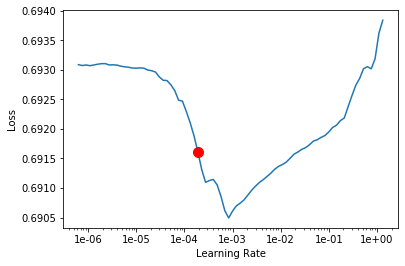

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.682444,0.681462,0.735294,0.264706,00:48
1,0.679537,0.679896,0.788916,0.211084,00:47


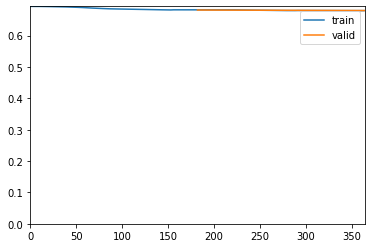

In [0]:
learner.fit_one_cycle(2, slice(1e-4))

In [0]:
learner.save('bert_84_overfitted')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 1.58E-07


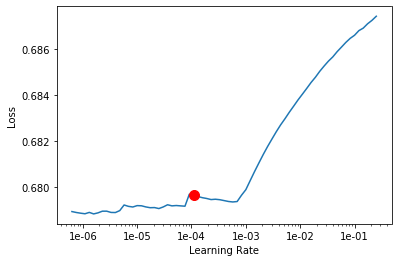

In [0]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.679781,0.680889,0.784714,0.215286,00:50
1,0.678661,0.680234,0.775310,0.224690,00:45


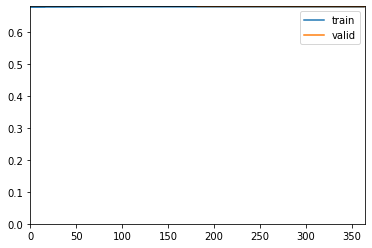

In [0]:
learner.fit_one_cycle(2, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.437795,0.461104,0.794841,0.205159,01:51
1,0.436195,0.449227,0.800096,0.199904,01:43
2,0.405618,0.439673,0.803200,0.196800,01:51
3,0.404058,0.436979,0.806066,0.193934,01:39
4,0.412446,0.436289,0.806305,0.193695,01:49


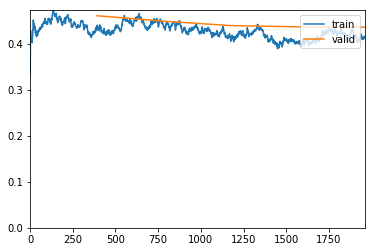

In [0]:
learner.fit_one_cycle(5, slice(5e-8))

In [0]:
# learner.load('model')

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [0]:
test_preds = get_preds_as_nparray(DatasetType.Test)
preds = []

In [0]:
for i in test_preds:
    preds.append(np.argmax(i))

In [0]:
from sklearn.metrics import classification_report, f1_score , recall_score, precision_score

In [0]:
print(classification_report(val['Label'], preds))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       551
           1       0.79      0.74      0.77       277

    accuracy                           0.85       828
   macro avg       0.83      0.82      0.83       828
weighted avg       0.85      0.85      0.85       828



In [0]:
f1_score(val['Label'], preds), recall_score(val['Label'], preds), precision_score(val['Label'], preds)

(0.7657992565055762, 0.7436823104693141, 0.789272030651341)

In [0]:
learner.save('bert_2',return_path=True)

PosixPath('models/bert_2.pth')